In [2]:
%run  InitAndFuctions.ipynb
#Bandella 

#KFC cosmici
runI          = [4035]
run_ped       = 4034

#KFC Fe
runI          = [4039]
run_ped       = 4038

cimax         = 10
cimin         = 0 
tag           = 'LAB'
nsigma        = 0.5
fiducial_cut  = 150 # pixel
version       = 'debug'
doRescale     = True
debug         = True
max_tarck     = 10
cfile = cy.open_(runI[0], tag=tag, posix=posix, verbose=False)
if cfile.x_resolution == 2048:
    rescale = 512 # orca flash
else:
    rescale = 576 # fusion


if not doRescale: 
    rescale = cfile.x_resolution
    
        
tscale = int(cfile.x_resolution/rescale)
print("rascale: ", tscale)
fiducial_cut = np.int(fiducial_cut/tscale)
#########################

m_image, s_image = cy.ped_(run_ped, path=mybasepath+'ped/')

#########################

th_image   = np.round(m_image + nsigma*s_image)
print ("light over Th: %.2f " % (th_image.sum()-m_image.sum()))
cfile = cy.open_(runI[0], tag=tag, posix=posix, verbose=True)
iTr=0

Host: e6c7635e19d5
3.6.8 (default, Nov 16 2020, 16:55:22) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-44)] <ipykernel.zmqshell.ZMQInteractiveShell object at 0x7f01f9c0e438>
Welcome to JupyROOT 6.22/06
rascale:  4
/workarea/cloud-storage/mazzitel/ped/run4038_mean.h5 /workarea/cloud-storage/mazzitel/ped/run4038_sigma.h5
light over Th: 9815004.83 
Open file: /workarea/cloud-storage/cygnus/Data/LAB/histograms_Run04039.root
Find Keys: 200
# of Images (TH2) Files: 200 
# of Waveform (TH2) Files: 0 
Camera X, Y pixel: 2304 2304 


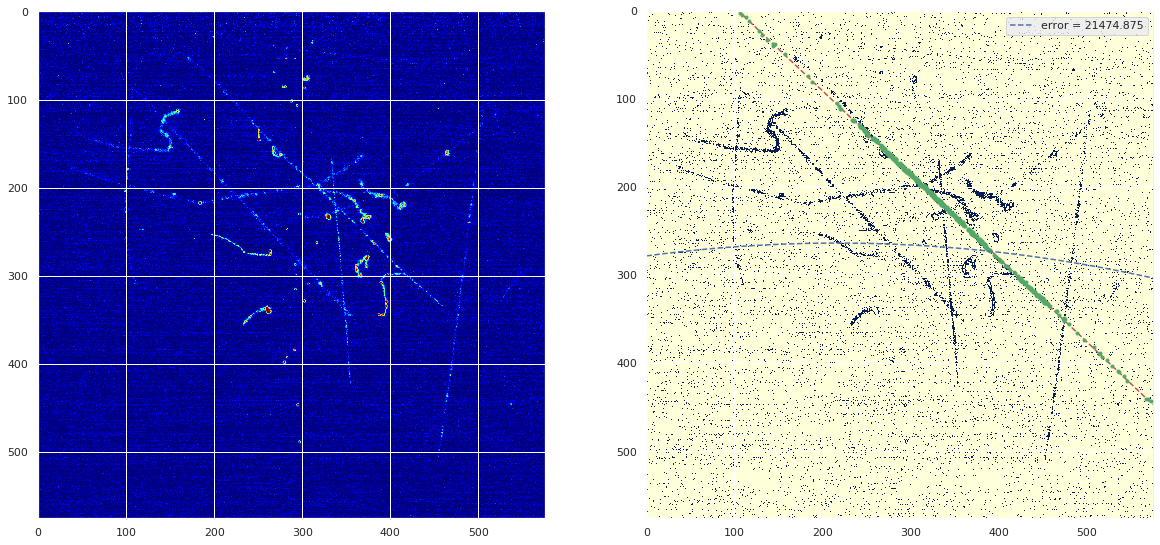

In [18]:
image = rtnp.hist2array(cfile.file.Get(cfile.pic[iTr])).T
raw_image       = np.subtract(image,m_image)
rebin_image     = cy.rebin(raw_image, (rescale, rescale))  
rebin_th_image  = cy.rebin((th_image-m_image), (rescale, rescale))
edges = (rebin_image > rebin_th_image) & (rebin_image < cimax)
points          = np.array(np.nonzero(edges)).T.astype(float)

y_values = points[:,0]
x_values = points[:,1]
poly_degree = 2


from sklearn.linear_model import (
    LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor)
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
# from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

# estimators = [('OLS', LinearRegression()),
#               ('Theil-Sen', TheilSenRegressor(random_state=42)),
#               ('RANSAC', RANSACRegressor(random_state=42)),
#               ('HuberRegressor', HuberRegressor())]

fig, ax = plt.subplots (1,2, figsize=(20,10))
ax[0].imshow(rebin_image, cmap='jet', vmin=0, vmax=20)
ax[1].imshow(edges, cmap='YlGnBu', vmin=0,vmax=1)
x_plot = np.arange(0, rebin_image.shape[1])


X = x_values[:, np.newaxis]
ransac = RANSACRegressor(min_samples=3, residual_threshold=2, max_trials=1000, random_state=42)
ransac.fit(X, y_values)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
ax[1].plot(x_plot, ransac.predict(x_plot[:, np.newaxis]) , 'r--')
ax[1].plot(points[inlier_mask,1], points[inlier_mask,0], 'g.')
# print('line fit: ', ransac.params)

# ax[1].plot(x_values, y_values, 'r.', markersize=1)

# x_values = points[inlier_mask,1]
# y_values = points[inlier_mask,0]
# X = x_values[:, np.newaxis]

model = Pipeline([
    ('feautures', PolynomialFeatures(poly_degree)), 
    ('estimator', ransac)
    ])
model.fit(X, y_values)

#print('line fit: ', ransac.params)


# inlier_mask = model.inlier_mask_

mse = mean_squared_error(model.predict(X), y_values)
y_plot = model.predict(x_plot[:, np.newaxis])
ax[1].plot(x_plot, y_plot, 'b--', label='error = %.3f' % (mse))


# 
ax[1].set_xlim(0, rebin_image.shape[1])
ax[1].set_ylim(rebin_image.shape[0], 0)
ax[1].legend()
plt.show()

In [16]:
model['estimator']


RANSACRegressor(base_estimator=None, is_data_valid=None, is_model_valid=None,
                loss='absolute_loss', max_skips=inf, max_trials=1000,
                min_samples=3, random_state=42, residual_threshold=2,
                stop_n_inliers=inf, stop_probability=0.99, stop_score=inf)

In [17]:
ransac

RANSACRegressor(base_estimator=None, is_data_valid=None, is_model_valid=None,
                loss='absolute_loss', max_skips=inf, max_trials=1000,
                min_samples=3, random_state=42, residual_threshold=2,
                stop_n_inliers=inf, stop_probability=0.99, stop_score=inf)